In [1]:
import os
from tqdm import tqdm
from glob import glob

import numpy as np
import pandas as pd

from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_parquet("./processed_dfs/coin_features_df_extract_features_7_1.parquet")

y_col = "img_type"
X_cols = df.drop(columns = [y_col, "img"]).columns

X_train, X_test, y_train, y_test = train_test_split(df[X_cols], df[y_col], test_size = 0.15, random_state = 0)

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: (2629, 96)
Test set shape: (464, 96)


In [3]:
params = {
    'max_depth': [2, 3],
    'min_samples_leaf': [2, 5, 7, 9, 11, 13, 15],
    'min_samples_split': [2, 3, 4, 5],
    'criterion': ["gini", "entropy"],
    'max_features': ["sqrt", "log2"],
}
scoring = {
    "Accuracy": "accuracy",
    "F1_MACRO": "f1_macro",
    "F1_MICRO": "f1_micro",
    "F1_WEIGHTED": "f1_weighted"
}

dt_clf = DecisionTreeClassifier(class_weight = "balanced", 
                                random_state = 0)

In [4]:
grid_search = GridSearchCV(estimator = dt_clf, 
                           param_grid = params, 
                           cv = 5,
                           n_jobs = -1,
                           verbose = 2,
                           scoring = scoring,
                           refit = "F1_MICRO",
                           return_train_score = True,
                           error_score = 'raise')

In [5]:
%%time

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits
[CV] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3; total time=   0.1s
[CV] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=4; total time=   0.1s
[CV] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.1s
[CV] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3; total time=   0.1s
[CV] END criterion=gini, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=3; total time=   0.1s


GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 3],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [2, 5, 7, 9, 11, 13, 15],
                         'min_samples_split': [2, 3, 4, 5]},
             refit='F1_MICRO', return_train_score=True,
             scoring={'Accuracy': 'accuracy', 'F1_MACRO': 'f1_macro',
                      'F1_MICRO': 'f1_micro', 'F1_WEIGHTED': 'f1_weighted'},
             verbose=2)

In [6]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,...,mean_test_F1_WEIGHTED,std_test_F1_WEIGHTED,rank_test_F1_WEIGHTED,split0_train_F1_WEIGHTED,split1_train_F1_WEIGHTED,split2_train_F1_WEIGHTED,split3_train_F1_WEIGHTED,split4_train_F1_WEIGHTED,mean_train_F1_WEIGHTED,std_train_F1_WEIGHTED
0,0.031810,0.005801,0.039437,0.004371,gini,2,sqrt,2,2,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",...,0.763178,0.015145,141,0.770552,0.773889,0.77429,0.765573,0.755909,0.768043,0.006824
1,0.029061,0.001417,0.034958,0.002180,gini,2,sqrt,2,3,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",...,0.763178,0.015145,141,0.770552,0.773889,0.77429,0.765573,0.755909,0.768043,0.006824
2,0.030050,0.003504,0.038865,0.007129,gini,2,sqrt,2,4,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",...,0.763178,0.015145,141,0.770552,0.773889,0.77429,0.765573,0.755909,0.768043,0.006824
3,0.027622,0.001508,0.037933,0.006340,gini,2,sqrt,2,5,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",...,0.763178,0.015145,141,0.770552,0.773889,0.77429,0.765573,0.755909,0.768043,0.006824
4,0.037076,0.012449,0.058719,0.033982,gini,2,sqrt,5,2,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",...,0.763178,0.015145,141,0.770552,0.773889,0.77429,0.765573,0.755909,0.768043,0.006824


In [7]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       max_features='sqrt', min_samples_leaf=2, random_state=0)
{'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
0.7885221799746516


<Axes: >

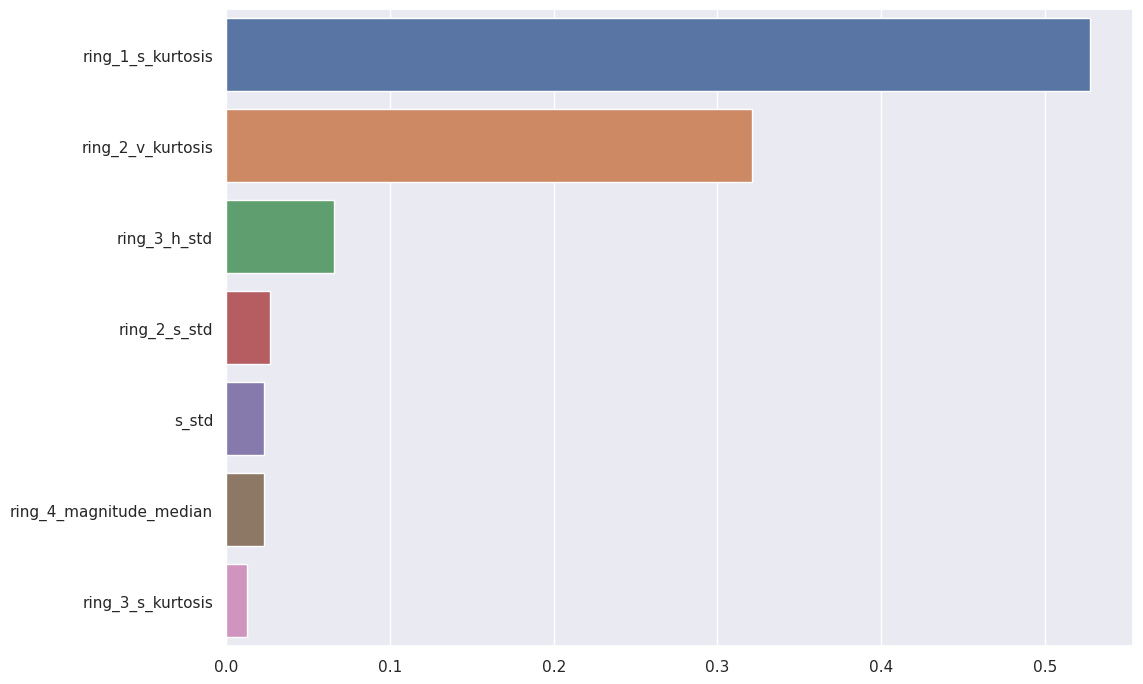

In [14]:
dt_best = grid_search.best_estimator_
feature_importances = dt_best.feature_importances_

sorted_indices = feature_importances.argsort()[::-1][:7]
sorted_feature_names = dt_best.feature_names_in_[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

sns.set(rc = {'figure.figsize':(11.7, 8.27)})
sns.barplot(y = sorted_feature_names, x = sorted_importances)

In [26]:
sorted_feature_names

array(['ring_1_s_kurtosis', 'ring_2_v_kurtosis', 'ring_3_h_std',
       'ring_2_s_std', 's_std', 'ring_4_magnitude_median',
       'ring_3_s_kurtosis'], dtype=object)

In [15]:
dt_clf = DecisionTreeClassifier(class_weight = 'balanced', 
                                criterion = 'entropy',
                                max_depth = 4, 
                                max_features = 'sqrt', 
                                min_samples_leaf = 2,
                                random_state = 0)
dt_clf.fit(X_train[sorted_feature_names], y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, max_features='sqrt', min_samples_leaf=2,
                       random_state=0)

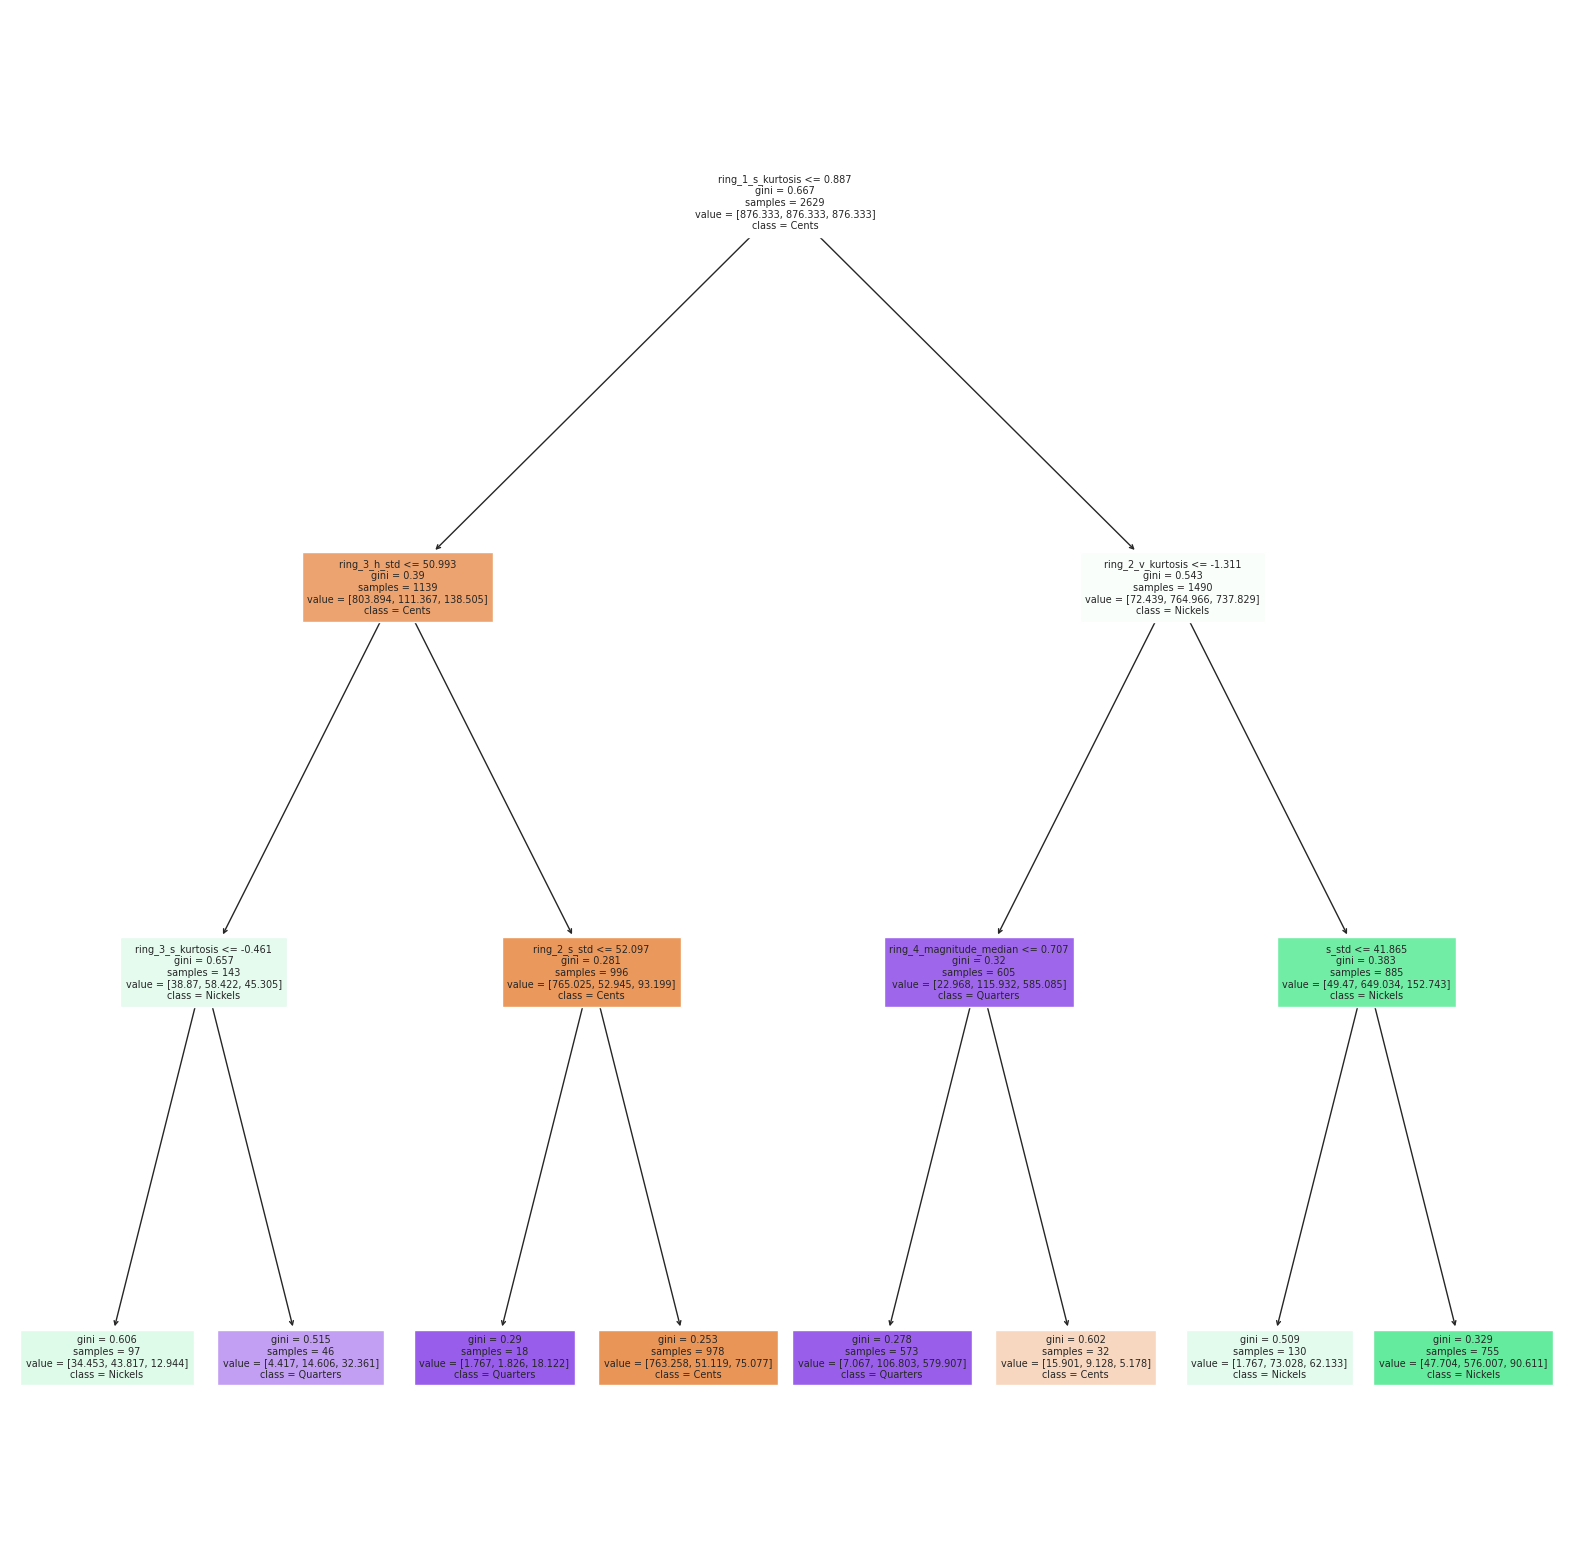

In [20]:
plt.figure(figsize = (20, 20)) 
plot_tree(dt_best, 
          feature_names = dt_best.feature_names_in_.tolist(), 
          class_names = dt_best.classes_.tolist(), 
          filled = True,
          fontsize = 7)
plt.show()

In [22]:
print(classification_report(y_test, dt_best.predict(X_test)))

              precision    recall  f1-score   support

       Cents       0.87      0.85      0.86       169
     Nickels       0.74      0.77      0.76       173
    Quarters       0.73      0.71      0.72       122

    accuracy                           0.79       464
   macro avg       0.78      0.78      0.78       464
weighted avg       0.79      0.79      0.79       464

